In [5]:
import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)


di.display_html('''<h3>Confusion matrix for tuned model given pre-scored data from Michelle. </h3>''', raw=True)

Toggle code

Confusion matrix for tuned model given pre-scored data from Michelle.

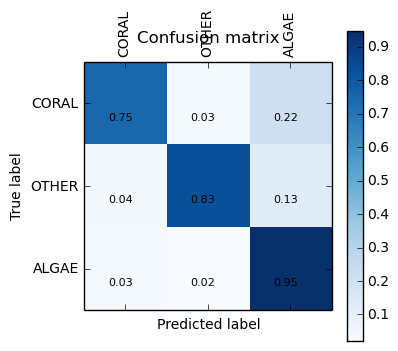

'Coverage: 87.2399445215%, Prediction score threshold: 0.9'

<function __main__.plot_dynamic_confusion>

In [3]:

from __future__ import print_function
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
import csv
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, classification_report, \
    precision_recall_curve
from matplotlib import pyplot as plt
import numpy as np
from IPython.display import display, HTML
import pandas as pd
from IPython.display import HTML
HTML("<i>Italic text goes here </i>")

%matplotlib inline

def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.matshow(cm, cmap=cmap)
    plt.title(title)
    plt.colorbar()
    #target_names = target_names
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=90)
    plt.yticks(tick_marks, target_names)
    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    for i, cas in enumerate(cm):
        for j, c in enumerate(cas):
            plt.text(j-.2, i+.2, "%.2f" % c, fontsize=8)

    #plt.savefig("confusion.png")
    plt.show()

def plot_precision_recall(precision, recall, thresholds, title):
    plt.clf()
    plt.plot(recall, precision, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    #plt.ylim([0.0, 1.05])
    #plt.xlim([0.0, 1.0])
    plt.title(title)
    plt.legend(loc="lower left")
    plt.show()

with open('bleaching-tune-predictions.csv') as csvfile:
#with open('gbr-predictions-nv.csv') as csvfile:
    reader = csv.DictReader(csvfile)
    rows = list(row for row in reader)

for row in rows:
    
    if row["PREDICTION"] == "HARD CORAL" or row["PREDICTION"] == "SOFT CORAL":
        row["PREDICTION"] = "CORAL"
    elif row["PREDICTION"] == "ALGAE":
        row["PREDICTION"] = "ALGAE"
    else:
        row["PREDICTION"] = "OTHER"
    
    if row["GROUP_CODE"] == "HC" or row["GROUP_CODE"] == "SC":
        row["GROUP_CODE"] = "CORAL"
    elif row["GROUP_CODE"] == "A":
        row["GROUP_CODE"] = "ALGAE"
    else:
        row["GROUP_CODE"] = "OTHER"

    
dataframe = pd.DataFrame(rows)
    
y_true = []
y_pred = []
y_yes_no = []
y_scores = []

def get_label_number(label, classes):
    for the_class in classes:
        if the_class in label:
            return classes.index(the_class)    

groups = ["HARD CORAL", "SOFT CORAL", "ABIOTIC", "ALGAE", "SPONGE", "SEAGRASS", "OTHER", "INDETERMINATE"]
groups_orig = ["HC", "SC", "AB", "A", "SP", "SG", "OT", "IN"]

groups = ["CORAL", "OTHER", "ALGAE"]
groups_orig = ["CORAL", "OTHER", "ALGAE"]


target_names = groups
chart_labels = groups
label_numbers = [index for index, item in enumerate(chart_labels)]

for row in rows:
    
    original = groups_orig.index(row["GROUP_CODE"])
    prediction = groups.index(row["PREDICTION"])
    predition_score = row["PREDICTION_SCORE"]
    
    y_true.append(original)
    y_pred.append(prediction)
    y_scores.append(float(predition_score))



def plot_dynamic_confusion(prediction_score_threshold=0.9):
        new_y_true = []
        new_y_pred = []
        new_y_scores = []
        
        for index, item in enumerate(y_scores):
            if item >= prediction_score_threshold:
                new_y_true.append(y_true[index])
                new_y_pred.append(y_pred[index])
                new_y_scores.append(y_scores[index])
        
        cm = confusion_matrix(new_y_true, new_y_pred, label_numbers)
        np.set_printoptions(precision=2)
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        plot_confusion_matrix(cm_normalized, chart_labels)
        
        return "Coverage: " + str( 100 - ((len(y_scores) - len(new_y_scores)) / float(len(y_scores)) * 100.0) ) + "%, " + "Prediction score threshold: 0.9" 


#print("**BOLD TEXT**")

interact(plot_dynamic_confusion, prediction_score_threshold=(0.00, 1.00, 0.001))

In [6]:
di.display_html('''<h3>Prediction accuracy for reef given pre-scored data from Michelle. </h3>''', raw=True)

Prediction accuracy for reef given pre-scored data from Michelle.

In [36]:


#print(dataframe.loc[dataframe['REEF_NAME'] == 'HAVANNAH REEF'])

def tally_reef_stats(reef_name, rows, prediction_score_threshold=0.9):
    correct = 0
    incorrect = 0
    coverage = 0
    
    groups_correct = {}
    groups_incorrect = {}
    
    for row in rows:
        original = groups_orig.index(row["GROUP_CODE"])
        prediction = groups.index(row["PREDICTION"])
        predition_score = float(row["PREDICTION_SCORE"])
        
        if predition_score >= prediction_score_threshold:
            coverage = coverage + 1
            if original == prediction:
                correct = correct + 1
                groups_correct[row["GROUP_CODE"]] = groups_correct.get(row["GROUP_CODE"], 0) + 1
            else:
                incorrect = incorrect + 1
                groups_incorrect[row["GROUP_CODE"]] = groups_incorrect.get(row["GROUP_CODE"], 0) + 1
    
    total = float(correct) / float(correct+incorrect) * 100.0
    coverage = float(coverage) / float(len(rows)) * 100.0
    total = "{0:.2f}".format(total) +"%"
    coverage = "{0:.2f}".format(coverage) +"%"
    #print(reef_name + " " + str(total) + " " + str(coverage))

    summary = {"Reef": reef_name, "Tot Accuracy": total, "Tot Coverage": coverage}
    for key in groups_orig:

        group_incor = groups_incorrect.get(key, 0)
        group_cor = groups_correct.get(key, 0)

        if group_incor+group_cor == 0:
            summary[str(key)] = "NA"
        else:
            summary[str(key)] = float(groups_correct.get(key, 0)) / (float(groups_correct.get(key, 0)) + float(groups_incorrect.get(key, 0))) * 100.0
            summary[str(key)] = "{0:.2f}".format(summary[str(key)]) +"%"

    return summary

def tally_reefs(prediction_score_threshold=0.9):
    #df = dataframe.sample(frac=0.1)
    
    reefs = dataframe['REEF_NAME'].unique()
    printable = []
    
    for reef in reefs:
        printable.append(tally_reef_stats(reef, dataframe.loc[dataframe['REEF_NAME'] == reef].to_dict('records'), prediction_score_threshold))
        
    new_df = pd.DataFrame(printable)
    new_df = new_df.fillna("NA")
    print(new_df.to_string())
    
    return "Prediction score threshold: 0.9" 


interact(tally_reefs, prediction_score_threshold=(0.00, 1.00, 0.001))

      ALGAE    CORAL    OTHER                    Reef Tot Accuracy Tot Coverage
0   100.00%   46.15%   71.43%             DAVIES REEF       81.25%       81.36%
1    88.46%   91.30%   66.67%        JOHN BREWER REEF       86.21%       86.57%
2    88.00%   89.66%  100.00%                RIB REEF       90.00%       84.51%
3   100.00%   64.29%   81.82%            PANDORA REEF       74.07%       77.14%
4    77.27%   87.50%   89.47%           HAVANNAH REEF       84.93%       87.95%
5   100.00%   76.47%  100.00%             COATES REEF       91.30%       92.00%
6    96.23%   57.14%   53.85%          ARLINGTON REEF       82.50%       84.21%
7    97.22%   66.67%  100.00%           HASTINGS REEF       95.65%       92.00%
8    93.94%   59.38%   81.25%              SAXON REEF       82.46%       91.20%
9   100.00%  100.00%  100.00%               OPAL REEF      100.00%       90.00%
10  100.00%   50.00%  100.00%  AGINCOURT REEFS (NO 1)       98.00%       89.29%


'Prediction score threshold: 0.9'

<function __main__.tally_reefs>